# CRAFTY. Flavio Romano, 614801

Carichiamo i dataset e importiamo le librerie necessarie

In [19]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import json
import time
import re

"""Datasets"""
transactions = pd.read_csv("./datasets/transactions.csv", names=["timestamp", "blockId", "txId", "isCoinbase", "fee"])
inputs = pd.read_csv("./datasets/inputs.csv", names=["txId", "prevTxId", "prevTxPos"])
outputs = pd.read_csv("./datasets/outputs.csv", names=["txId", "position", "addressId", "amount", "scriptType"])
mapping_df = pd.read_csv("./datasets/mapAddr2Ids8708820.csv", names=["hash", "addressId"])

transactions['timestamp'] = pd.to_datetime(transactions['timestamp'], unit='s')

Ho convertito la colonna `timespamp` del dataframe `transactions` in una serie `dateTime`, ogni entry conterrà data e ora in formato 
$$yyyy \textit{-} mm \textit{-} dd\quad hh:mm:ss$$

## 1. Analisi generali sui dati

### I. Distribuzione del numero di transazioni per blocco (occupazione del blocco), nell’intero periodo temporale considerato


Eseguo una `groupby()` sull'attributo `blockId` del dataframe delle transazioni, utilizzo la funzione di aggregazione `count()` sulla colonna `txId`.
- Ciò mi restituisce una serie in cui a ogni `blockId` (indice) corrisponde il numero di transazioni effettuate. 

Come strumento di plotting ho scelto un line plot 
- ho scelto di visualizzare l'asse y in **scala logaritmica**, per permettere una migliore visualizzazione degli _spikes_ del grafico.

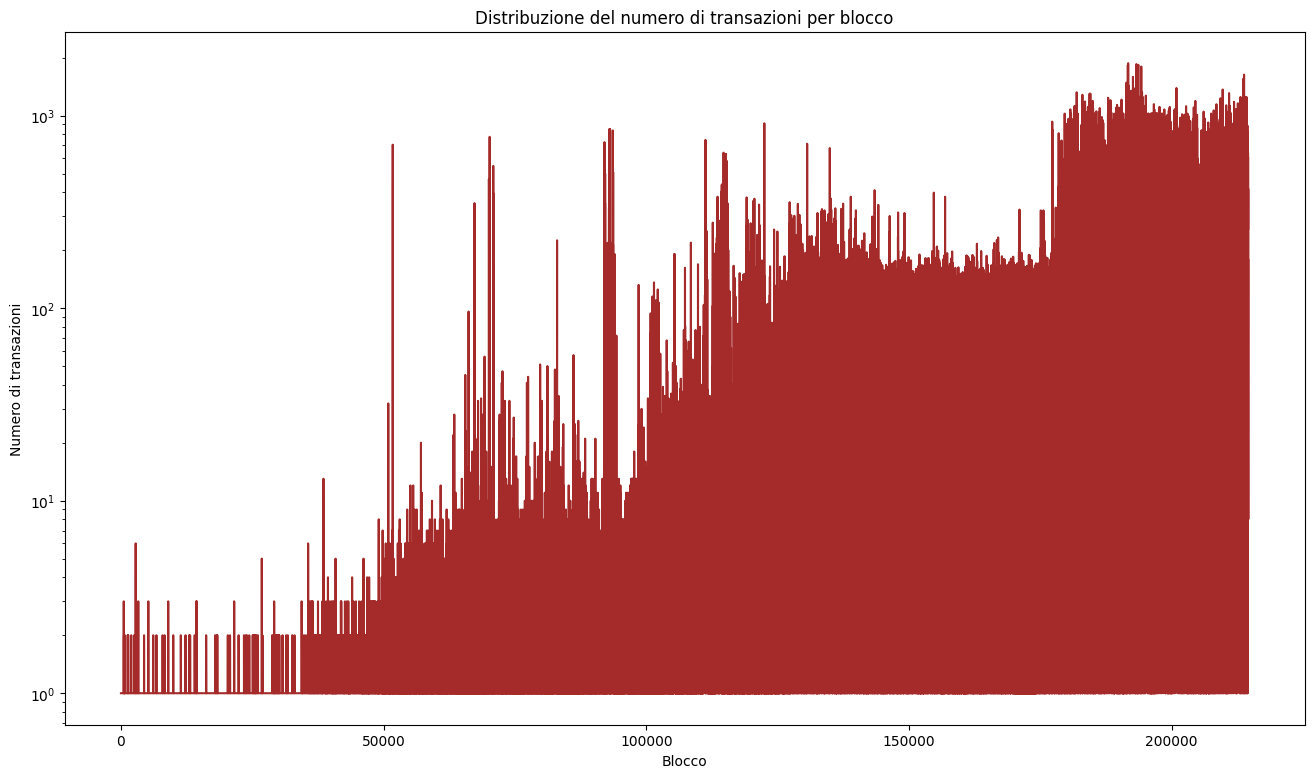

In [2]:
transactions_per_block = transactions.groupby("blockId")["txId"].count()

plt.figure(figsize=(16,9))
transactions_per_block.plot(color="brown")
plt.xlabel("Blocco")
plt.ylabel("Numero di transazioni")
plt.title("Distribuzione del numero di transazioni per blocco")

plt.yscale("log")
plt.show()

### II. Evoluzione dell'occupazione dei blocchi nel tempo (2 mesi)

1. `twoMonth_dtIndex` è un DateTimeIndex, cioè una lista di timestamp a partire da `transactions["timestamp"].iloc[1]` (primo timestamp) fino a `transactions["timestamp"].iloc[-1]` (ultimo timestamp) a frequenza mensile.
2. `months_dict` è un dizionario: 
    - con chiavi le coppia di mesi (e.g: "jan-feb")
    - con valori delle liste
        - ogni lista contiene il numero di transazioni medie relative alla coppia di mesi, ordinati per anno. e.g: `months_dict["jan-feb"][1]` conterrà il numero medio di transazioni per Gennaio-Febbraio 2010.
3. Per ogni coppia di date:
    - seleziono le transazioni comprese tra le due date
    - le raggruppo per `blockId` e utilizzo la funzione di aggregazione `count()` sull'attributo `timestamp`
    - attraverso la funzione `mean()` ottengo la media per la coppia di mesi
    - aggiungo la media alla lista corretta, in base al primo mese della coppia presa in esame.

In [3]:
twoMonth_dtIndex = pd.date_range(start=transactions["timestamp"].iloc[1], end=transactions["timestamp"].iloc[-1], freq="M")
months_dict = dict({"jan-feb": list(), "mar-apr": list(), "may-jun": list(), "jul-aug": list(), "sept-oct": list(), "nov-dec": list()})

for i in range(0, len(twoMonth_dtIndex)-1, 2):
    two_months = transactions[transactions['timestamp'].between(twoMonth_dtIndex[i], twoMonth_dtIndex[i + 1])]
    two_months_mean = two_months.groupby('blockId')["timestamp"].count().mean()
    match twoMonth_dtIndex[i].month_name():
        case "January":
            months_dict["jan-feb"].append(two_months_mean)
        case "March":
            months_dict["mar-apr"].append(two_months_mean)
        case "May":
            months_dict["may-jun"].append(two_months_mean)
        case "July":
            months_dict["jul-aug"].append(two_months_mean)
        case "September":
            months_dict["sept-oct"].append(two_months_mean)
        case "November":
            months_dict["nov-dec"].append(two_months_mean)

Come strumento per il plotting ho scelto il _bar grouped plot_, ottimi per visualizzare dati che variano nel tempo e metterli a confronto.
- Creo un nuovo dataframe a partire dal dizionario con le medie delle coppie di mesi e indicizzato sugli anni.
- Così diventa molto semplice plottare _bar grouped plot_, basta specificare `stacked=False` per non avere le barre impilate.
- Ho scelto di plottare il grafico sia in scala decimale che logaritmica per stressare l'utilità di quest'ultima in contesti dove i dati sono talmente piccoli da sembrare indistinguibili.

        jan-feb    mar-apr     may-jun     jul-aug    sept-oct     nov-dec
2009   1.028329   1.004155    1.006745    1.004769    1.006981    1.007834
2010   1.028297   1.889842    1.406853    2.018113    2.501807    3.039165
2011   8.408163  14.052931   50.532829   54.029841   45.298823   37.811128
2012  48.212387  52.989252  216.839207  225.988071  201.074307  273.724138


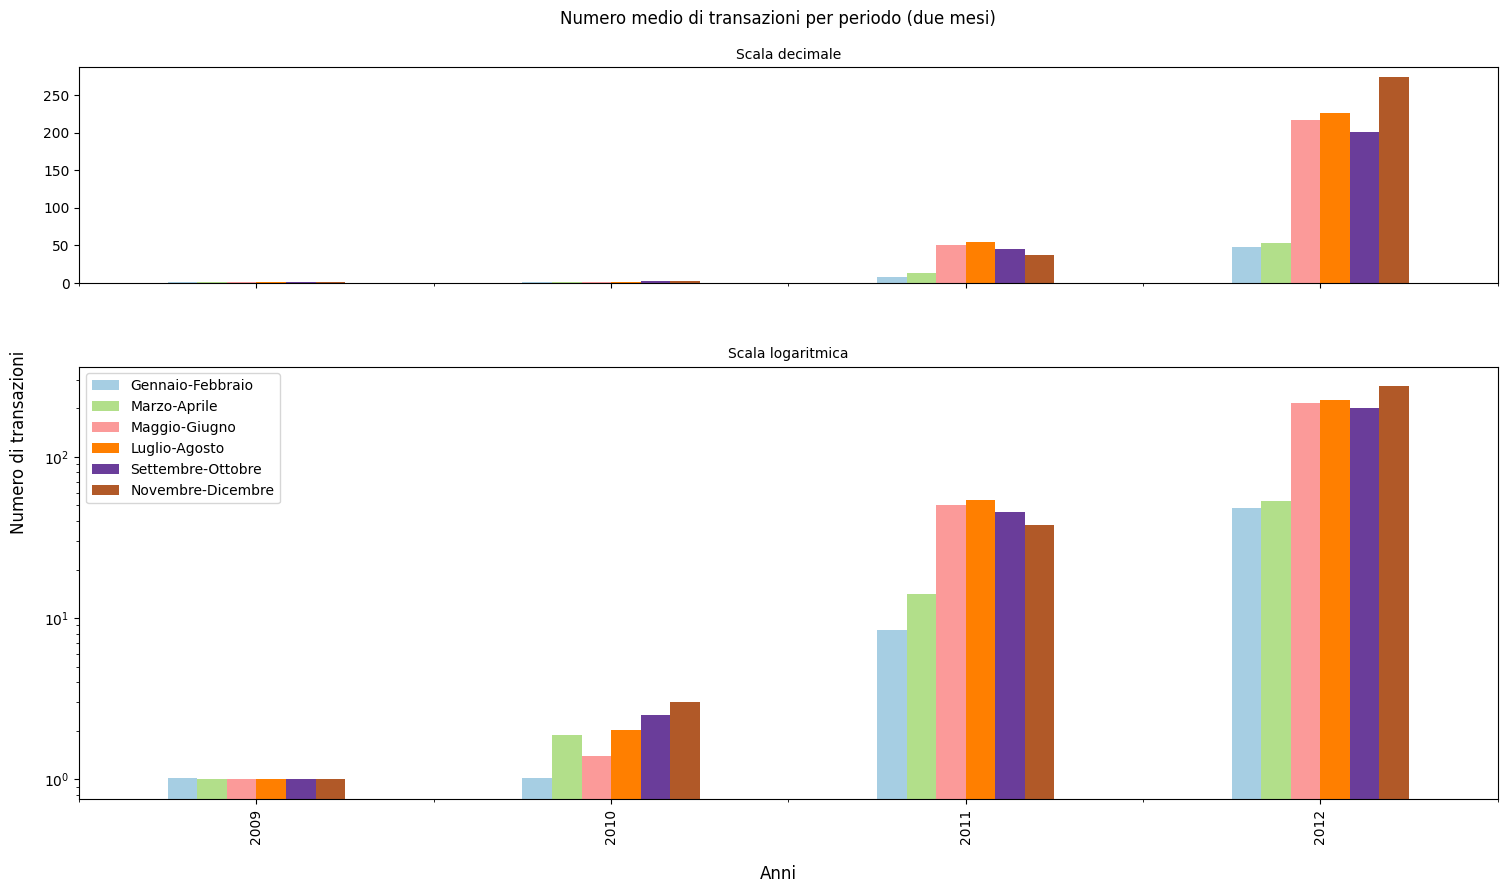

In [4]:
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(
    16, 9), gridspec_kw={'height_ratios': [1, 2]})
fig.tight_layout(pad=5)
fig.suptitle("Numero medio di transazioni per periodo (due mesi)")
fig.supylabel("Numero di transazioni")
fig.supxlabel("Anni")

years = [2009, 2010, 2011, 2012]
df = pd.DataFrame(months_dict, index=years)
print(df)

ax1.set_title("Scala decimale", fontsize=10)
df.plot(ax=ax1, kind="bar", stacked=False, colormap="Paired")

ax2.set_title("Scala logaritmica", fontsize=10)
df.plot(ax=ax2, kind="bar", stacked=False, colormap="Paired")

ax2.set_yscale("log")
ax1.get_legend().remove()

plt.legend(["Gennaio-Febbraio", "Marzo-Aprile", "Maggio-Giugno",
           "Luglio-Agosto", "Settembre-Ottobre", "Novembre-Dicembre"], loc="best")
plt.show()

Com'è facilmente osservabile,  Gennaio-Febbraio è il periodo che negli anni si mantiene sempre più basso rispetto agli altri.

### III. Ammontare totale degli UTXO al momento dell’ultima transazione

- `temp` è il dataframe risultante dal merge tra `outputs` e `inputs` (_inner_ perché voglio l'intersezione), contiene tutti gli _output_ che sono stati _input_ di una transazione.
- `temp.amount.sum()` è l'ammontare degli output spesi, quindi per trovare l'ammontare di UTXO devo sottrarre è sufficiente sottrarre questo valore all'ammontare di _output_ totali.

In [5]:
# output che sono stati input di una transazione
temp = outputs.merge(inputs, how='inner', left_on=["txId", "position"], right_on=["prevTxId", "prevTxPos"])
utxo = outputs.amount.sum() - temp.amount.sum()
print(utxo)

859303372614879


### IV. Distribuzione degli intervalli di tempo che intercorrono tra la transazione che genera un valore in output e quella che lo consuma

- `spent` è il dataframe risultante dal merge tra `transactions` e `inputs` su `txId`, contiene i `timestamp` di quando è stato speso un dato _output_.
- `created` è il dataframe risultante dal merge tra `transactions` e `outputs` su `txId`, contiene i `timestamp` di quando è stato creato un dato _output_
- `diff` è il dataframe risultante dal merge dei due dataframe appena creati, contiene sia la data di creazione che quella di spesa. 
    - aggiungo la colonna chiamata `timestamp_difference` a cui assegno i giorni che intercorrono tra la spesa e la creazione (la sottrazione `diff.timestamp_spent - diff.timestamp_created` restituisce una serie di cui a me interessano i giorni, per questo uso `dt.days`)
    - rimuovo tutte le righe per cui questa differenza è negativa, in quanto non è possibile che un output venga speso **prima** di essere generato. (inconsistenze)

In [6]:
spent = transactions.merge(inputs, on="txId").rename(columns={"timestamp": "timestamp_spent"}).loc[:,["timestamp_spent", "txId", "prevTxId", "prevTxPos"]]
created = transactions.merge(outputs, on="txId").rename(columns={"timestamp": "timestamp_created"}).loc[:,["timestamp_created", "txId", "position"]]
created = created.rename(columns={"txId": "outTxId"})

diff = spent.merge(created, how="inner", left_on=["prevTxId", "prevTxPos"], right_on=["outTxId", "position"]).loc[:, ["timestamp_created", "timestamp_spent", "prevTxId"]]

diff["timestamp_difference"] = (diff.timestamp_spent - diff.timestamp_created).dt.days
diff.drop(diff[diff.timestamp_difference < 0].index, inplace=True) 

- `df` è il dataframe risultante di una `groupby()` su `timestamp_difference`, contiene il numero di output spesi dopo un certo numero di giorni perché uso la funzione di aggregazione `count()` su `prevTxId`.

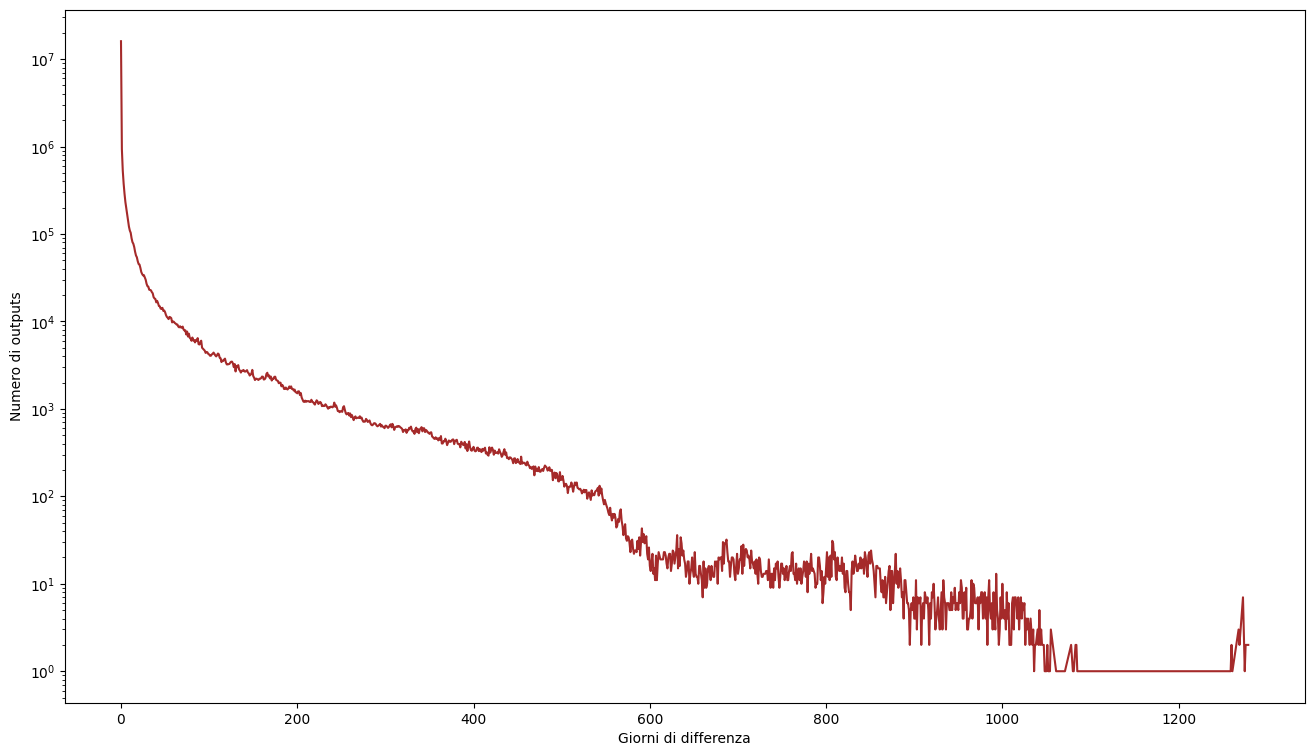

In [20]:
plt.figure(figsize=(16, 9))
df = diff.groupby("timestamp_difference")["prevTxId"].count()
plt.plot(df.index, df.values, color="brown")

plt.yscale("log")
plt.ylabel("Numero di outputs")
plt.xlabel("Giorni di differenza")
plt.show()

Dal grafico è facilmente osservabile che la maggior parte output vengono spesi dopo pochi giorni dalla loro creazione.

### V. Evoluzione dei 3 address più ricchi (UTXO)

- `temp` è una maschera per ottenere le entry in cui il `txId` dell'_output_ non è `prevTxId` degli _inputs_ (cioè proprio gli Unspent Transaction Outputs)
- `utxo` contiene le entry del dataframe `outputs` non spese.

Per ottenere i 3 indirizzi più ricchi:
- `utxo_address` è il risultato della `groupby()` per `addressId` su `utxo`, eseguo una `sum()` su `amount` per ottenere per ogni `addressId` (indice) il numero totale di UTXO. Ordino su `amount` per ottenere facilmente i primi 3 indirizzi più ricchi.

In [8]:
temp = (~outputs["txId"].isin(inputs["prevTxId"]))
utxo = outputs.loc[temp].loc[:,["addressId", "amount", "txId"]]
utxo_address = utxo.groupby(by="addressId").sum("amount").sort_values(by="amount", ascending=False).loc[:,["amount"]]
top_3_utxo = utxo_address.head(3).merge(mapping_df, how="inner", left_index=True, right_on="addressId").drop(columns=["addressId"])

address1, address2, address3 = top_3_utxo.index
print(top_3_utxo)

                amount                                hash
2770941  4972966980000  13vJZKHKBirruXwmjMaRtakzPQRRHQit1S
1083446  4716866106997  1933phfhK3ZgFQNLGSDXvqCn32k2buXY8a
6755311  4000000000000  1BqcwhKevdBKeos72b8E32Swjrp4iDVnjP


Voglio visualizzare l'evoluzione nel tempo di questi address, quindi mi servono i timestamp degli UTXO per tutt'e tre gli address. 

In [9]:
utxo_address1 = utxo.loc[utxo.addressId == address1].merge(transactions, on="txId")[["addressId", "amount", "timestamp"]]
utxo_address2 = utxo.loc[utxo.addressId == address2].merge(transactions, on="txId")[["addressId", "amount", "timestamp"]]
utxo_address3 = utxo.loc[utxo.addressId == address3].merge(transactions, on="txId")[["addressId", "amount", "timestamp"]]

Noto che solo l'address2 ha effettivamente uno _storico_ che varia nel tempo
- `df_address2` è indicizzato per timestamp e contiene le somme cumulative degli UTXO nel tempo.

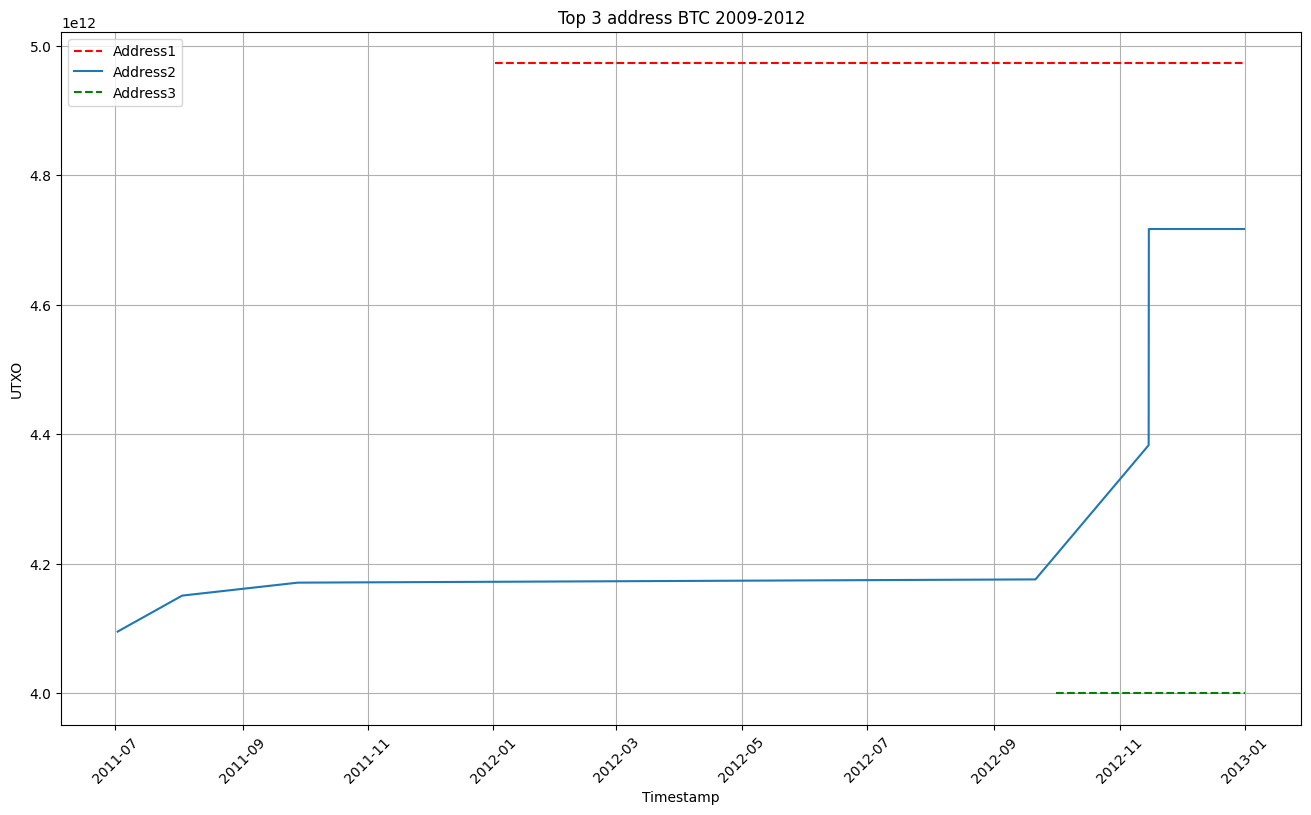

In [10]:
df_address2 = pd.DataFrame()
df_address2["amount"] = utxo_address2.cumsum()["amount"]
df_address2.index = utxo_address2["timestamp"]

timestamp_max = transactions["timestamp"].iloc[-1]

plt.figure(figsize=(16, 9))

# address1
plt.hlines(y=top_3_utxo.loc[address1].amount,color='r', linestyle='--', label='Address1', xmin=utxo_address1.timestamp, xmax=timestamp_max)

# address2
plt.plot(df_address2.index, df_address2['amount'], label="Address2")
plt.hlines(y=df_address2.loc[max(df_address2.index)], xmin=max(df_address2.index), xmax=timestamp_max)

# address3
plt.hlines(y=top_3_utxo.loc[address3].amount, color='g', linestyle='--', label='Address3', xmin=utxo_address3.timestamp, xmax=timestamp_max)

plt.xlabel('Timestamp')
plt.ylabel('UTXO')
plt.title('Top 3 address BTC 2009-2012')
plt.xticks(rotation=45)
plt.grid()
plt.legend(loc="upper left")

plt.show()

Ho verificato la correttezza del plotting su bitinfocharts

- [address1](https://bitinfocharts.com/bitcoin/address/13vJZKHKBirruXwmjMaRtakzPQRRHQit1S)
- [address2](https://bitinfocharts.com/bitcoin/address/1933phfhK3ZgFQNLGSDXvqCn32k2buXY8a) 
- [address3](https://bitinfocharts.com/bitcoin/address/1BqcwhKevdBKeos72b8E32Swjrp4iDVnjP)

## 2. Clusterizzazione degli indirizzi di Bitcoin: euristica multi-input

- `inputs_transaction` è il risultato del merge tra i dataframe `inputs` e `transactions`, contiene tutte le transazioni e i loro input. 
    - se più righe hanno lo stesso `txId` allora vuol dire che la transazione a cui si riferiscono è multi-input.
    - con una `groupby()` sull'attributo `txId` e un `count()` conto il numero di input per ogni transazione.
- voglio associare allo stesso utente tutti gli addressId utilizzati nell'input della stessa transazione.
    - `multi_inputs_transaction` è il dataframe creato a partire da `inputs_transaction`, nello specifico vengono selezionate solo le righe che hanno più di un input (`tmp.loc[tmp.values > 1].index` seleziono nella series gli indici delle transazioni per cui `count()` risulta maggiore di 1)
    - associo ad ogni input il proprio `addressId` facendo un merge con il dataframe `outputs`.

In [11]:
# considerare transazioni con input > 1
inputs_transaction = inputs.merge(transactions, on="txId", how="inner").loc[:, ['txId', 'prevTxId', 'prevTxPos']]
tmp = inputs_transaction.groupby("txId")["prevTxId"].count() # tmp.index == txId's

# associare allo stesso utente tutti gli addressId utilizzati nell'input della stessa transazione
multi_inputs_transaction = (inputs_transaction.loc[inputs_transaction["txId"].isin(tmp.loc[tmp.values > 1].index)]).reset_index(drop=True)
multi_inputs_transaction = multi_inputs_transaction.merge(outputs, left_on=["prevTxId", "prevTxPos"], right_on=["txId", "position"], how="inner")
multi_inputs_transaction = multi_inputs_transaction.loc[:, ['txId_x', 'addressId']].rename(columns={"txId_x": "txId"}).set_index("addressId")
print(multi_inputs_transaction)

               txId
addressId          
367             504
192             504
255             504
555             557
533             557
...             ...
8707915    10572820
8707915    10572820
8707915    10572820
3524243    10572826
6137717    10572826

[14120915 rows x 1 columns]


- `set_index("addressId")` mi permette di sfruttare l'attributo `groups` dell'oggetto restituito dalla `groupby()` su `txId` in `multi_inputs_transaction`
    - accedendo a `groups` ho un dizionario in cui le chiavi sono `txId` e i valori sono liste di `addressId` di tali input.

In [12]:
# crea mapping (transazione: [indirizzi])
multi_inputs_dict = multi_inputs_transaction.groupby("txId").groups

- `graph` è un grafo orientato i cui nodi sono indirizzi presenti nel dataset.
- per ogni transazione in `multi_inputs_dict` aggiungo un arco orientato che va **dal nodo con indirizzo del primo input** agli altri **nodi che rappresentano gli indirizzi degli altri input**.
    - uso la classe `DiGraph` di `networkX`, essa **garantisce l'assenza di archi ripetuti**.
    - quindi dovrò solo assicurarmi che non siano presenti **self loops**.
- `wcc` è una lista di componenti _debolmente_ connesse del grafo, in particolare è una lista popolata da `set` di `addressId`.

In [13]:
graph = nx.DiGraph()
graph.add_nodes_from(mapping_df["addressId"])

for addressIds in multi_inputs_dict.values():
    first_node = addressIds[0]
    for address in addressIds[1:]:
        if address != first_node:
            graph.add_edge(first_node, address)
nx.freeze(graph)

wcc = list(nx.weakly_connected_components(graph)) # lista di set di addressId

Questi controlli mi assicurano di aver clusterizzato a dovere, senza self loop e senza archi ripetuti.

In [14]:
if len(list(nx.nodes_with_selfloops(graph))) != 0:
    print("> Error... trovato self loop con primo address")

for addressIds in multi_inputs_dict.values():
    first_node = addressIds[0]
    for address in addressIds[1:]:
        if graph.number_of_edges(first_node, address) > 1:
            print("> Error... trovato arco ripetuto")
            break

### I. Statistiche grafo

In [15]:
cluster_dim = [len(c) for c in wcc]
max_cluster = max(wcc, key=len)
mean_cluster = sum(cluster_dim)/len(cluster_dim)
min_cluster = min(wcc, key=len)
number_of_singlets = sum(1 for c in wcc if len(c) == 1)

print(f'{len(cluster_dim):9,} - #cluster')
print(f'{len(max_cluster):9,} - #cluster più grande')
print(f'{len(min_cluster):9} - #cluster più piccolo')
print(f'{mean_cluster:9.2f} - Dimensione media dei cluster')
print(f'{number_of_singlets:9,} - Numero di "singoletti"')

4,800,614 - #cluster
  259,773 - #cluster più grande
        1 - #cluster più piccolo
     1.81 - Dimensione media dei cluster
4,302,594 - Numero di "singoletti"


### II. Grafico

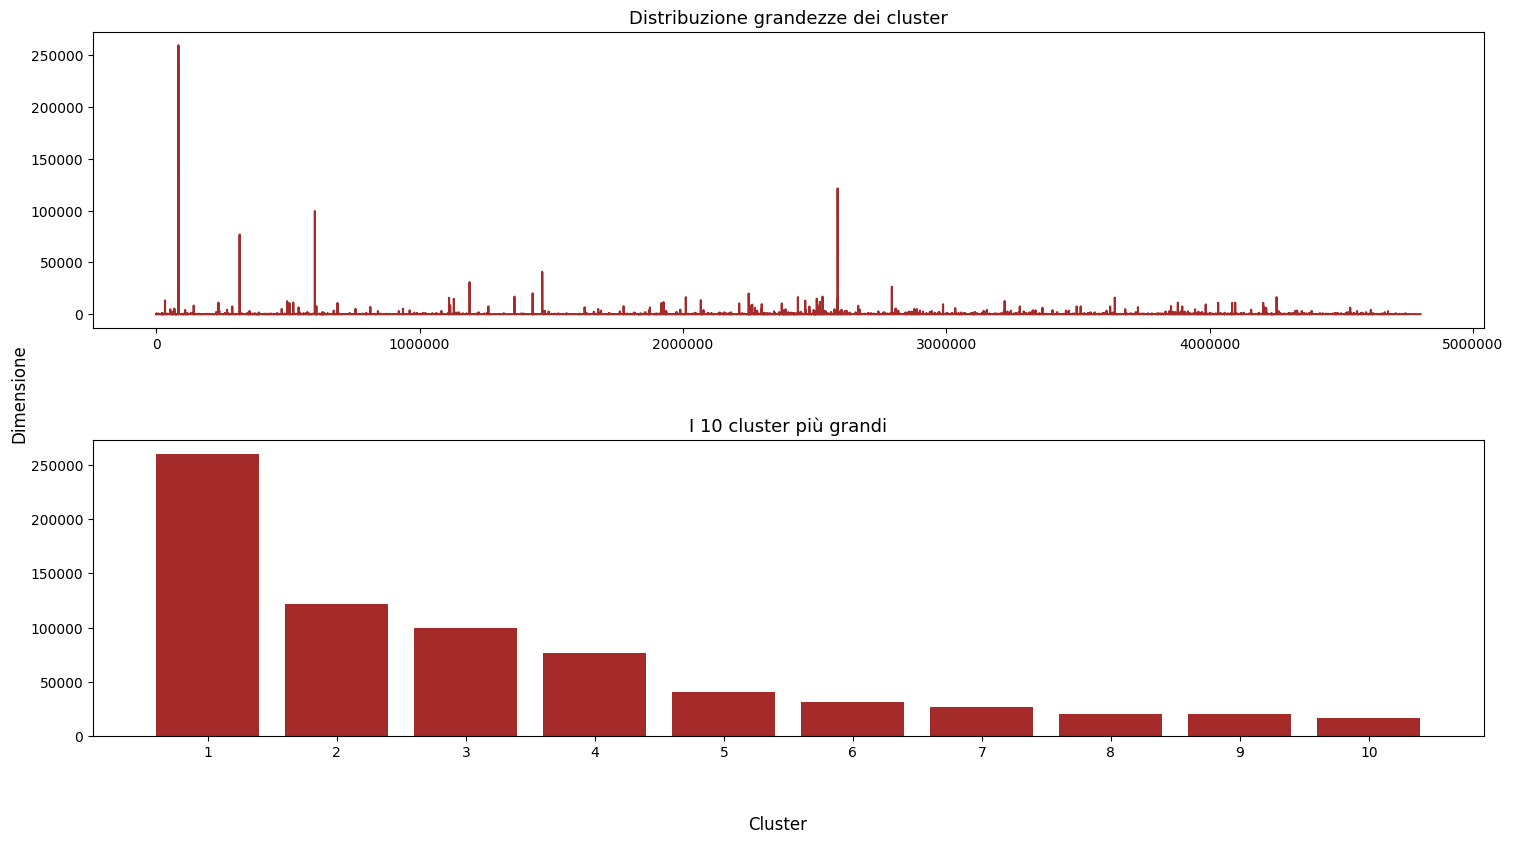

In [16]:
import heapq

biggest_clusters = heapq.nlargest(10, wcc, key=len)

fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(16, 9))
fig.tight_layout(pad=6)
fig.supxlabel('Cluster')
fig.supylabel('Dimensione')

ax1.set_title("Distribuzione grandezze dei cluster", fontsize=13)
ax1.ticklabel_format(useOffset=False, style="plain")
# ax1.set_yscale("log")
ax1.plot(cluster_dim, color="brown")

ax2.set_title("I 10 cluster più grandi", fontsize=13)
xticks = range(1,11,1)
ax2.bar(x=xticks, height=[len(c) for c in biggest_clusters], tick_label=xticks, color="brown")

plt.show()

## 3. Deanonimizzazione degli indirizzi

Vogliamo deanonimizzare più indirizzi possibili per associare ad ogni cluster un determinato wallet, o service, a cui appartiene.
- Consideriamo i 10 cluster di dimensione maggiore
- Dato un cluster, per ogni indirizzo del cluster eseguo una query
    - deanonimizzando un indirizzo, implicitamente tutti gli indirizzi del cluster possono essere associati allo stesso wallet

### WalletExplorer

La funzione `deanon_walletExplorer` prende in input un cluster e un intero.

- Apre una sessione persistente con `with requests.Session() as session` che dura per tutta l'esecuzione della funzione
    - Per ogni indirizzo all'interno del cluster
        - Trova l'hash a cui esso è associato all'interno del dataframe `mapping_df`
        - Esegue una `get` a `walletExplorer` aggiungendo all'url di partenza l'hash trovato al punto precedente
        - Salva la risposta e con `BeautifulSoup` la parsa cercando l'header `h2`:
            - se fa match con la regex (cioè è un qualsiasi stringa compresa tra due quadre "[]") allora **NON È** un nome di un wallet, deve continuare
            - altrimenti ho trovato il wallet name, quindi ho deanonimizzato un indirizzo.
    - Restituisce un wallet name da associare a un cluster oppure `None`.

Mediamente impiega 10-11 minuti.

In [ ]:
from bs4 import BeautifulSoup
from http import client
import requests

clusters_WalletExplorer = dict()
# cambio l'header per mascherare il fatto che stia utilizzando python per inviare richieste
header = {"User-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"}
rate_limit = 10
try_limit = 3

def deanon_walletExplorer(cluster, it):
    current_try = 1
    with requests.Session() as session:
        for addressId in cluster:
            if current_try == try_limit:
                break
            if it == rate_limit:
                # rate limit reached
                it = 1
                current_try += 1
                time.sleep(40)
            hash_addr = mapping_df.loc[mapping_df["addressId"] == addressId].iloc[0]["hash"]
            url = f"http://www.walletexplorer.com/?q={hash_addr}"
            try:
                response = session.get(url, headers=header)
                it += 1
                soup = BeautifulSoup(response.text, "html.parser")
                if response.ok:
                    try:
                        wallet_name = soup.find("h2").text.split()[1]
                        if re.match("\[.*?\]", wallet_name) is None:
                            return (wallet_name, it)
                    except AttributeError:
                        pass
            except (requests.exceptions.RequestException, client.RemoteDisconnected):
                pass
            time.sleep(1)
    return (None, it)

it = 1
for i, cluster in enumerate(biggest_clusters):
    cluster_name = f"Cluster{i+1}"
    print(f"Analyzing {cluster_name}...",end=" ")
    res, it = deanon_walletExplorer(cluster, it)
    print(f"{'*'if res is None else res}")
    clusters_WalletExplorer[cluster_name] = res

In [ ]:
with open("./walletsWalletExplorer.json", "w+") as f:
    f.write(json.dumps(clusters_WalletExplorer, indent=8))

#### Risultati

Sono riuscito a deanonimizzare 5 cluster su 10
```json
{
        "Cluster1": "CoinJoinMess",
        "Cluster2": "SilkRoadMarketplace",
        "Cluster3": null,
        "Cluster4": "Instawallet.org",
        "Cluster5": null,
        "Cluster6": "BTC-e.com-old",
        "Cluster7": "BtcDice.com",
        "Cluster8": null,
        "Cluster9": null,
        "Cluster10": null
}
```

#### Problemi

La principale avversità riscontrata durante la deanonimizzazione con WalletExplorer è stata

##### Http 429, TOO MANY REQUESTS. 

Purtroppo il servizio limita il numero di richieste al secondo, ciò è una grande limitazione visto che si parla di cluster con un numero veramente elevato di nodi. Per far fronte a questo problema, ho scelta una strategia conservativa dove
    - ogni secondo si fa una `get`
    - si incrementa `it`
    - non appena `it == rate_limit (== 10)` siamo molto vicini all'http 429, quindi 
        - si resetta `it` a 1
        - si incrementa `current_try`
        - si aspetta 40 secondi e si riparte
    - se `current_try == try_limit (== 3)` vuol dire che da questo cluster, visto che vogliamo seguire una politica _best effort_, difficilmente si caverà un ragno dal buco. Quindi restituisce `None` perché impiega troppo tempo.

#### Valore di `rate_limit`

Per calcolare il limite delle richieste al secondo ho scritto uno script Python
    
- all'interno di un `while True` incremento un contatore ogni volta che mando una `get` a WalletExplorer. 
- Non appena arriva Http 429 (verificabile dalla proprietà `status_code` dell'oggetto `response` della libreria `requests`, o semplicemente da `response.ok`) interrompo il loop. 

Mediamente il contatore arrivava a 12-13, quindi ho scelto `rate_limit = 10` preventiva.

nota. Per quanto riguarda la `sleep` di cooldown, ho scelto 40 sec. dopo delle verifiche fatte con la libreria `time` seguendo lo stesso principio di `rate_limit`. Spesso con una risposta http 429 è presente un header `retry-after` per indicare al client quanto tempo deve aspettare prima di inviare una nuova richiesta, purtroppo WalletExplorer non lo utilizza.
> _A Retry-After header might be included to this response indicating how long to wait before making a new request._ 
>
> \- [developer.mozilla.org](https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/429)

### Bitinfochart

Per questa parte ho usato Selenium perché:

- volevo sfruttare le espressioni _xpath_ (requests out-of-the-box non lo permette)
- volevo usare le _explicit wait_

La funzione `deanon_BitInfoChart` prende in ingresso un cluster

- apre una nuova istanza di ChromeDriver e la assegna alla variabile driver. L'argomento options è un dizionario con cui configuro il webdriver, in particolare:
    - `--headless=new` impedisce l'apertura di una nuova finestra di Chrome controllata da Python
    - `--user-agent=...` cambia l'user-agent all'interno del payload delle richieste fatte dal client, rende più complicato rilevare che non è un utente reale ad effettuare quelle richieste.
- Per ogni `addressId` contenuto in un cluster:
    - trovo l'hash dell'indirizzo all'interno del dataframe `mapping_df`
    - compongo l'url di richiesta con quest'ultimo
    - all'interno del `try ... except` 
        - eseguo una `get` all'url che contiene l'hash dell'indirizzo
        - il driver aspetta che compaia il nome del wallet (o codice numerico) tramite il suo _xpath_ (è un link all'interno tabella)
        - se non è un numero allora è proprio il nome del wallet, quindi lo restituisce.
        - altrimenti prosegue.
    - se non è stato trovato nessun wallet name dopo 20 tentativi consecutivi, allora restituisce ``None``.

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.wait import WebDriverWait
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.support import expected_conditions as EC

options = Options()
#options.add_argument("--headless=new")
options.add_argument("--user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36")


def deanon_BitInfoChart(cluster):
    try_limit = 0
    with webdriver.Chrome(options=options) as driver:
        for addressId in cluster:
            if try_limit == 20:
                break
            hash_addr = mapping_df.loc[mapping_df["addressId"]
                                    == addressId].iloc[0]["hash"]
            url = f"https://bitinfocharts.com/bitcoin/address/{hash_addr}"
            try:
                driver.get(url)
                r = WebDriverWait(driver, timeout=10, poll_frequency=1).until(
                    EC.presence_of_element_located((By.XPATH, "/html/body/div[3]/div[3]/table/tbody/tr/td/table/tbody/tr[1]/td[2]/small/a")))
                wallet_name = r.get_attribute("href").split("/")[-1]
                try_limit += 1
                if not wallet_name.isnumeric():
                    return wallet_name
            except (NoSuchElementException, AttributeError):
                pass
            time.sleep(1)
    return None

clusters_BitInfoChart = dict()
for i, cluster in enumerate(biggest_clusters):
    cluster_name = f"Cluster{i+1}"
    print(f"Analyzing {cluster_name}...", end=" ")
    res = deanon_BitInfoChart(cluster)
    print(f"{'*'if res is None else res}")
    clusters_BitInfoChart[cluster_name] = res

Analyzing Cluster1... F2Pool
Analyzing Cluster2... SilkRoadMarketplace
Analyzing Cluster3... *
Analyzing Cluster4... Instawallet.org
Analyzing Cluster5... *
Analyzing Cluster6... Eligius
Analyzing Cluster7... *
Analyzing Cluster8... *
Analyzing Cluster9... *
Analyzing Cluster10... *


#### Politica best-effort
Viene restituito `None` dopo 20 tentativi consecutivi senza successo, di deanonimizzazione, nello stesso cluster.

In [ ]:
with open("./walletsBitInfoChart.json", "w+") as f:
    f.write(json.dumps(clusters_BitInfoChart, indent=8))

### Risultati

Sono riuscito a deanonimizzare 4 cluster su 10
```json
{
        "Cluster1": "F2Pool",
        "Cluster2": "SilkRoadMarketplace",
        "Cluster3": null,
        "Cluster4": "Instawallet",
        "Cluster5": null,
        "Cluster6": "Eligius",
        "Cluster7": null,
        "Cluster8": null,
        "Cluster9": null,
        "Cluster10": null
}
```

#### Problemi

##### Captcha
BitInfoChart utilizza _CAPTCHA Cloudflare_ per evitare che vengano fatte troppe richieste al sito e riesce quindi a riconoscere che chi sta facendo le richieste sia un bot o meno. Purtroppo rendono inutilizzabile questo scraper perché l'IP viene bannato per un po' di tempo (se prima non si risolve il CAPTCHA). 
Vi sono due soluzioni:

1. Esistono API a pagamento che offrono servizi per bypassare _CAPTCHA Cloudfare V2_, ma non ho voluto utilizzarle.
2. Con una VPN possiamo accedere al sito da un'altra località geografica, e con un altro IP, mascherando la nostra identità.

##### HTTP 429
Anche qui per le troppe richieste viene mandato un errore 429, come abbiamo visto in precedenza ciò rende impossibile fare scraping di tutti gli address in tempi umani.

## 3bis. Considerazioni finali

- Deanonimizzare così tanti indirizzi in tempo ragionevole è difficile.
- Il problema principale è relativo al tempo da una richiesta all'altra, velocizzare il processo di deanonimizzazione porta a incorrere frequentemente in errori come Http 429. 
- Applicare una politica best-effort (mirata a deanonimizzare più cluster possibili nel minor tempo possibile) porta a deanonimizzare un numero di cluster minore rispetto a quello reale.
- Utilizzare siti diversi per la deanonimizzazione produce risultati diversi, probabilmente perché gli algoritmi che utilizzano sono diversi (e.g: walletExplorer utilizza una versione molto simile a quella implementata in questo progetto)

### Osservazioni su WalletExplorer
Per quanto riguarda l'algoritmo usato da walletExplorer:
>Just a basic algorithm is used to determine wallet addresses. Addresses are merged together, if they are co-spent in one transaction. So if addresses A and B are co-spent in transaction T1, and addresses B and C are co-spent in transaction T2, all addresses A, B and C will be part of one wallet. Sometimes, an address belongs to some service but it was never co-spent with others. Then that address stays unnamed. It is typically more often at addresses with higher amount (as there is no need to co-spending).

quindi se due indirizzi appaiono come input nella stessa transazione allora appartengano allo stesso wallet (presumibilmente), questo perché è necessario avere entrambe le chiavi private per firmare la transazione.

### Wallet deanonimizzati
1. **CoinJoin** è una tecnica di privacy utilizzata nelle transazioni delle criptovalute, come Bitcoin. Consiste nell'unire insieme diverse transazioni in un'unica transazione, in modo che diventi difficile o impossibile determinare quale input corrisponda a quale output. In una transazione CoinJoin, più partecipanti combinano i loro fondi in una transazione condivisa. Questo processo mescola gli input e gli output delle transazioni, creando un insieme di dati confusi che rende difficile tracciare i flussi di denaro. Poiché più transazioni vengono combinate insieme, diventa sempre più difficile determinare le corrispondenze esatte tra gli input e gli output.

2. **Silk Road Marketplace** era un mercato online illegale noto per essere stato uno dei primi e più famosi "darknet market" (mercati nascosti su internet) dedicati principalmente al commercio di droghe illegali.  Ooperava sulla rete Tor, che permette di navigare in maniera anonima, e accettava pagamenti solo in Bitcoin. Il sito forniva una piattaforma per venditori e acquirenti di droghe illegali, ma si dice che abbia anche ospitato la vendita di altri beni illegali come armi, documenti falsi e malware.

3. **Instawallet** era un servizio di portafoglio Bitcoin online che consentiva agli utenti di archiviare, inviare e ricevere Bitcoin. Gli utenti di Instawallet ricevevano un indirizzo Bitcoin unico associato al proprio account, che potevano utilizzare per ricevere pagamenti. Tuttavia, a differenza dei portafogli tradizionali in cui gli utenti controllano direttamente le chiavi private dei loro indirizzi Bitcoin, Instawallet teneva in custodia le chiavi private degli utenti. Ha subito un attacco informatico nel 2013 che ha portato alla compromissione dei dati degli utenti e alla perdita di Bitcoin. A seguito dell'attacco, il servizio è stato interrotto e non è stato più ripristinato.

4. **BTC-e** era uno dei più grandi servici di scambio di criptovalute, forniva un servizio per l'acquisto, la vendita e lo scambio di diverse criptovalute, tra cui Bitcoin, Litecoin, Ethereum e altre. Gli utenti potevano depositare fondi nelle loro controparti virtuali e scambiarli con altre criptovalute o valute _FIAT_ come il dollaro statunitense o l'euro. Nel 2017, le autorità statunitensi hanno accusato BTC-e di essere coinvolto in attività di riciclaggio di denaro e di facilitare il commercio di beni illeciti. In seguito, il dominio BTC-e.com è stato sequestrato dalle autorità e l'accesso al sito è stato interrotto.

5. **Btcdice** è un sito web che offre un servizio di gioco d'azzardo basato su Bitcoin. Gli utenti effettuano una scommessa in Bitcoin e il sito genera un numero casuale tra 0 e 65,535. In base al numero generato, viene determinato il risultato della scommessa. e.g: se il numero generato è inferiore a un valore predefinito, la scommessa può essere considerata vincente e l'utente riceverà un pagamento in base alle regole specifiche del sito.

6. **F2Pool** è uno dei più grandi pool di mining di criptovalute al mondo. Si concentra principalmente sul mining di Bitcoin (BTC), ma supporta anche altre criptovalute come Ethereum (ETH), Litecoin (LTC) e Zcash (ZEC). Un _pool di mining_ è un gruppo di minatori che uniscono le loro risorse di calcolo per aumentare le probabilità di risolvere i complessi problemi matematici necessari per validare le transazioni e produrre nuovi blocchi nella blockchain. I partecipanti al pool condividono quindi le ricompense proporzionalmente alla potenza di calcolo che contribuiscono.

7. **Eligius** era uno dei primi pool di mining di Bitcoin, era molto popolare nella comunità delle criptovalute. Il valore aggiunto di Eligius era la sua politica di pagamento _pay-per-share_ (PPS), che garantiva ai minatori una ricompensa proporzionale alla loro contribuzione alla potenza di calcolo del pool. Ciò significa che i minatori venivano pagati per ogni quota di lavoro inviata al pool, indipendentemente dal fatto che il blocco fosse stato effettivamente trovato o meno. Questo modello di pagamento era considerato vantaggioso per i minatori, poiché offriva un flusso di ricompense costante anche se la frequenza di blocco del pool poteva variare. Nel 2017, Eligius ha annunciato la chiusura del pool di mining a causa di sfide operative e di sostenibilità. Molti dei suoi minatori si sono quindi spostati su altri pool di mining disponibili.